In [21]:
import polars as pl 


data = pl.read_csv("output/output.csv", infer_schema_length = 10000)

In [22]:
downstream = data["downstream"].to_list()
upstream = data["upstream"].to_list()


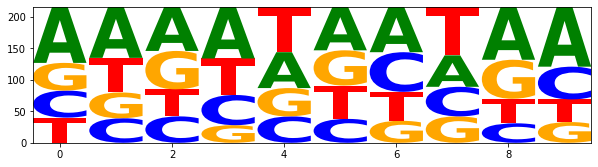

In [25]:
import logomaker as lm 
import pandas as pd
from Bio import motifs
from Bio.Seq import Seq

seqs = [Seq(kmer) for kmer in downstream]
m = motifs.create(seqs)
pfm = m.counts
pwm = m.counts.normalize(pseudocounts=0.5)  # pseudocounts prevents dividing by zero
pwm_df = pd.DataFrame(pfm)
logo = lm.Logo(pwm_df)

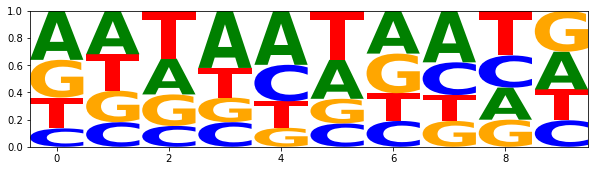

In [26]:
seqs = [Seq(kmer) for kmer in upstream]
m = motifs.create(seqs)
pfm = m.counts
pwm = m.counts.normalize(pseudocounts=0.5)  # pseudocounts prevents dividing by zero
pwm_df = pd.DataFrame(pwm)
logo = lm.Logo(pwm_df)

In [27]:
downstream
counts_mat = lm.alignment_to_matrix(downstream)
counts_mat.head()

['GAAGGGCGAG',
 'AAACTTCAGA',
 'AAGAGATGCC',
 'TACTCTATTT',
 'CAGAAAGTCC',
 'AATATTATAG',
 'CCGTTGGTCA',
 'TTCATAATAT',
 'CATACTGGAA',
 'TTGGTATTAT',
 'TTCAAAGTTT',
 'AGATTGCAGA',
 'AAACATTTCC',
 'CTGAAGATTT',
 'CGAAAATATC',
 'GATTTACTTG',
 'CAAACGTTAT',
 'ACGAGCAAAA',
 'AGCAAAGACA',
 'ACAAATTTGC',
 'TTGCATCTCA',
 'GATTTTCTGA',
 'AAGTTAGTAC',
 'AGGCAAAGAC',
 'ATAAATTCAA',
 'AAACCGCGGA',
 'TGTAGACCCA',
 'GTCTATTTGA',
 'CTAGATAAAC',
 'AAGGTTCTGG',
 'CCACATCTTC',
 'TTTTACAGTG',
 'TTTCCAAGGT',
 'ACAACCTGTA',
 'ATTATTCGAA',
 'ATGCTGCAAC',
 'ACTTTGTTCA',
 'AAGAATCTCA',
 'TTGATAATAG',
 'AGCGCGAGGG',
 'AACCAATTGT',
 'CGATGCGGTA',
 'GAGATAACCA',
 'ATTCCAAAAC',
 'GTTTCATTAA',
 'AAAGCACCAG',
 'AGATACGCTT',
 'TGTCATGGTT',
 'AGGGTTTTGC',
 'GAGAGCAAGA',
 'CAGAAATGGA',
 'TCTTTTTGGA',
 'CGCGGACCTC',
 'AAGAAGTTGA',
 'TATTCGAGAA',
 'AACAATCAAT',
 'CTAGACCGGC',
 'GCGTCTTTAC',
 'AACCGGACGA',
 'AAACTACTCA',
 'GGGACGAATA',
 'CCGGCTCAAA',
 'CAAATACTGG',
 'GACTTCCAAA',
 'CTCTCTCTCC',
 'ATAATATCAC',
 'CTTTTCCT